In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import copy
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# Optuna Visualization Tools
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# ==============================
# 1. LOAD & CONFIG
# ==============================
CHOSEN_CROP = "rice" 
TARGET_COL = f"Y_{CHOSEN_CROP}"
PARQUET_PATH = "Parquet/XY_v3.parquet"
SEQ_LEN     = 5              # try larger windows; model uses past SEQ_LEN years
BATCH_SIZE  = 32
CLIP_QUANT  = 0.01           # 1%-99% clipping to tame outliers
EPOCHS      = 100
PATIENCE    = 15
LR          = 2e-4

df = pd.read_parquet(PARQUET_PATH)
df = df[(df["year"] >= 1982) & (df["year"] <= 2023)].copy()
df = df.dropna(subset=[TARGET_COL]).copy()
print(f"--> Filtered years (1982-2023) and dropped NaN targets. New Shape: {df.shape}")

LAG_1_FEATURE = f'avg_yield_{CHOSEN_CROP}_1y'


--> Filtered years (1982-2023) and dropped NaN targets. New Shape: (4687, 75)


In [3]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. PREPROCESSING + SEQUENCE BUILDING  (WITH VERBOSE PRINTS)
# ============================================================
def preprocess_and_build_loaders(
    df: pd.DataFrame,
    chosen_crop: str,
    target_col: str,
    seq_len: int = 5,
    batch_size: int = 32,
    clip_quant: float = 0.01,
):
    """
    Full preprocessing + sequence-building pipeline for panel time series LSTM.
    Now with verbose prints so you can see what each step is doing.
    """

    print("========== PREPROCESSING START ==========")
    print(f"Chosen crop: {chosen_crop}")
    print(f"Target col:  {target_col}")
    print(f"Seq len:     {seq_len}")
    print(f"Batch size:  {batch_size}")
    print("-----------------------------------------")

    df_model = df.copy()
    print(f"Initial df shape: {df_model.shape}")

    # -------------------------------------------
    # 1) Drop rows with NaN target
    # -------------------------------------------
    n_before = len(df_model)
    df_model = df_model[~df_model[target_col].isna()].copy()
    n_after = len(df_model)
    print(f"[Step 1] Dropped rows with NaN target: {n_before - n_after} rows removed")
    print(f"        Remaining rows: {n_after}")

    # -------------------------------------------
    # 1.5) Remove min/max target per country (area)
    # -------------------------------------------
    print("[Step 1.5] Removing per-area min/max target rows as outliers...")

    # ensure we still have area + target
    if "area" not in df_model.columns:
        raise ValueError("'area' column not found in df for min/max removal")

    # indices of min and max target per area
    idx_min = df_model.groupby("area")[target_col].idxmin().values
    idx_max = df_model.groupby("area")[target_col].idxmax().values

    rows_to_drop = np.unique(np.concatenate([idx_min, idx_max]))
    n_before_mm = len(df_model)
    df_model = df_model.loc[~df_model.index.isin(rows_to_drop)].reset_index(drop=True)
    n_after_mm = len(df_model)

    print(f"        Dropped {n_before_mm - n_after_mm} rows (min + max per area).")
    print(f"        Remaining rows after outlier removal: {n_after_mm}")

    # -------------------------------------------
    # 2) Target & feature selection
    # -------------------------------------------
    print("[Step 2] Target & feature selection...")
    # Drop other target columns
    all_targets = [c for c in df_model.columns if c.startswith("Y_")]
    drop_other_targets = [c for c in all_targets if c != target_col]
    df_model = df_model.drop(columns=drop_other_targets)
    print(f"        Target columns found: {all_targets}")
    print(f"        Keeping target: {target_col}")
    print(f"        Dropping other targets: {drop_other_targets}")

    # Drop unrelated avg_yield_* columns
    avg_yield_cols = [c for c in df_model.columns if c.startswith("avg_yield_")]
    chosen_prefix = f"avg_yield_{chosen_crop}_"
    keep_avg_yield = [c for c in avg_yield_cols if c.startswith(chosen_prefix)]
    drop_avg_yield = list(set(avg_yield_cols) - set(keep_avg_yield))
    df_model = df_model.drop(columns=drop_avg_yield)

    print(f"        Total avg_yield_* cols: {len(avg_yield_cols)}")
    print(f"        Keeping {len(keep_avg_yield)} for {chosen_crop}")
    print(f"        Dropping {len(drop_avg_yield)} from other crops")

    # -------------------------------------------
    # 3) Add time features (trend over years)
    # -------------------------------------------
    print("[Step 3] Adding time features year_index and year_norm...")
    base_year = df_model["year"].min()
    df_model["year_index"] = df_model["year"] - base_year
    max_index = df_model["year_index"].max() if df_model["year_index"].max() > 0 else 1
    df_model["year_norm"] = df_model["year_index"] / max_index
    print(f"        Base year: {base_year}")
    print(f"        Max year_index: {max_index}")
    print(f"        year range in df: {df_model['year'].min()}–{df_model['year'].max()}")

    # -------------------------------------------
    # 4) Sort for time consistency
    # -------------------------------------------
    print("[Step 4] Sorting by ['area', 'year']...")
    df_model = df_model.sort_values(["area", "year"]).reset_index(drop=True)
    print(f"        After sort shape: {df_model.shape}")

    # -------------------------------------------
    # 5) Define feature columns
    # -------------------------------------------
    feature_cols = [
        c
        for c in df_model.columns
        if c not in ["area", "year", target_col] and not c.startswith("Y_")
    ]
    print("[Step 5] Defining feature columns...")
    print(f"        Selected {len(feature_cols)} input features for prediction.")
    print(f"        First 10 features: {feature_cols[:10]}")

    # -------------------------------------------
    # 6) Group-wise ffill/bfill for feature columns
    # -------------------------------------------
    print("[Step 6] Group-wise ffill/bfill within each area...")
    na_before = df_model[feature_cols].isna().sum().sum()
    df_model[feature_cols] = (
        df_model.groupby("area", group_keys=False)[feature_cols]
        .apply(lambda g: g.ffill().bfill())
    )
    na_after = df_model[feature_cols].isna().sum().sum()
    print(f"        NaNs before ffill/bfill: {na_before}")
    print(f"        NaNs after  ffill/bfill: {na_after}")

    # -------------------------------------------
    # 7) Time-based masks (on rows; for scaling only)
    # -------------------------------------------
    print("[Step 7] Creating time-based masks (rows)...")
    train_mask_rows = df_model["year"] < 2014
    val_mask_rows   = (df_model["year"] >= 2014) & (df_model["year"] <= 2018)
    test_mask_rows  = df_model["year"] >= 2019

    print(f"        Train rows: {int(train_mask_rows.sum())}")
    print(f"        Val rows:   {int(val_mask_rows.sum())}")
    print(f"        Test rows:  {int(test_mask_rows.sum())}")

    # -------------------------------------------
    # 8) Raw arrays + NaN imputation (train-mean)
    # -------------------------------------------
    print("[Step 8] Building raw arrays and imputing remaining NaNs with train mean...")
    X_raw = df_model[feature_cols].values.astype(np.float32)
    y_raw = df_model[[target_col]].values.astype(np.float32)

    train_X = X_raw[train_mask_rows]
    train_mean = np.nanmean(train_X, axis=0)
    nan_inds = np.where(np.isnan(X_raw))
    n_nan_total = len(nan_inds[0])
    print(f"        Remaining NaNs before mean-impute: {n_nan_total}")
    X_raw[nan_inds] = np.take(train_mean, nan_inds[1])
    print("        NaNs after mean-impute: 0")

    # -------------------------------------------
    # 9) Outlier clipping (train-based quantiles)
    # -------------------------------------------
    if clip_quant is not None and 0.0 < clip_quant < 0.5:
        print(f"[Step 9] Clipping outliers using train quantiles {clip_quant:.2f} and {1-clip_quant:.2f}...")
        train_X_no_nan = X_raw[train_mask_rows]
        q_low = np.quantile(train_X_no_nan, clip_quant, axis=0)
        q_high = np.quantile(train_X_no_nan, 1.0 - clip_quant, axis=0)

        n_clipped_cols = 0
        for j in range(train_X_no_nan.shape[1]):
            if q_low[j] < q_high[j]:
                X_raw[:, j] = np.clip(X_raw[:, j], q_low[j], q_high[j])
                n_clipped_cols += 1
        print(f"        Columns clipped: {n_clipped_cols}/{train_X_no_nan.shape[1]}")
    else:
        print("[Step 9] Skipping clipping (clip_quant is None or invalid).")

    # -------------------------------------------
    # 10) Scaling (fit only on train)
    # -------------------------------------------
    print("[Step 10] Scaling X and y (StandardScaler, train-only fit)...")
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = X_raw.copy()
    y_scaled = y_raw.copy()

    X_scaled[train_mask_rows] = scaler_X.fit_transform(X_raw[train_mask_rows])
    X_scaled[val_mask_rows]   = scaler_X.transform(X_raw[val_mask_rows])
    X_scaled[test_mask_rows]  = scaler_X.transform(X_raw[test_mask_rows])

    y_scaled[train_mask_rows] = scaler_y.fit_transform(y_raw[train_mask_rows])
    y_scaled[val_mask_rows]   = scaler_y.transform(y_raw[val_mask_rows])
    y_scaled[test_mask_rows]  = scaler_y.transform(y_raw[test_mask_rows])

    print("        Scaling complete.")
    print(f"        y_scaled train mean (should be ~0): {y_scaled[train_mask_rows].mean():.4f}")
    print(f"        y_scaled train std  (should be ~1): {y_scaled[train_mask_rows].std():.4f}")

    # -------------------------------------------
    # 11) Rebuild scaled DataFrame for sequences
    # -------------------------------------------
    print("[Step 11] Rebuilding scaled DataFrame for sequence building...")
    df_scaled = df_model[["area", "year"]].copy()
    df_scaled["target_scaled"] = y_scaled.reshape(-1)

    X_df = pd.DataFrame(X_scaled, columns=feature_cols, index=df_model.index)
    df_final = pd.concat([df_scaled, X_df], axis=1)
    print(f"        df_final shape: {df_final.shape}")
    print("        Sample df_final head():")
    print(df_final.head())

    # -------------------------------------------
    # 12) Sequence building with split by TARGET YEAR
    # -------------------------------------------
    print("[Step 12] Building sequences and splitting by TARGET YEAR...")

    def build_sequences_by_split(
        df_seq: pd.DataFrame,
        feat_cols: list,
        target_col_name: str,
        seq_len_inner: int,
    ):
        X_train_list, y_train_list = [], []
        X_val_list, y_val_list     = [], []
        X_test_list, y_test_list   = [], []

        for _, g in df_seq.groupby("area"):
            g = g.sort_values("year")
            feats = g[feat_cols].values.astype(np.float32)
            targs = g[target_col_name].values.astype(np.float32)
            years = g["year"].values

            if len(g) < seq_len_inner:
                continue

            # Sliding window: [t-seq_len+1 ... t] -> target at t
            for i in range(len(g) - seq_len_inner + 1):
                X_seq = feats[i : i + seq_len_inner]
                y_t   = targs[i + seq_len_inner - 1]
                y_yr  = years[i + seq_len_inner - 1]

                if y_yr < 2014:
                    X_train_list.append(X_seq)
                    y_train_list.append(y_t)
                elif 2014 <= y_yr <= 2018:
                    X_val_list.append(X_seq)
                    y_val_list.append(y_t)
                else:  # y_yr >= 2019
                    X_test_list.append(X_seq)
                    y_test_list.append(y_t)

        def to_array(x_list, y_list):
            if len(x_list) == 0:
                return (
                    np.empty((0, seq_len_inner, len(feat_cols)), dtype=np.float32),
                    np.empty((0,), dtype=np.float32),
                )
            X_arr = np.stack(x_list).astype(np.float32)
            y_arr = np.array(y_list, dtype=np.float32)
            return X_arr, y_arr

        X_tr, y_tr = to_array(X_train_list, y_train_list)
        X_v, y_v   = to_array(X_val_list, y_val_list)
        X_te, y_te = to_array(X_test_list, y_test_list)

        return X_tr, y_tr, X_v, y_v, X_te, y_te

    X_train, y_train, X_val, y_val, X_test, y_test = build_sequences_by_split(
        df_final,
        feature_cols,
        "target_scaled",
        seq_len,
    )

    print(f"        Sequence shapes:")
    print(f"           Train: {X_train.shape}, targets: {y_train.shape}")
    print(f"           Val:   {y_val.shape}, targets: {y_val.shape}")
    print(f"           Test:  {X_test.shape}, targets: {y_test.shape}")

    # -------------------------------------------
    # 13) Build PyTorch DataLoaders
    # -------------------------------------------
    print("[Step 13] Building PyTorch DataLoaders...")

    def make_loader(X, y, batch_size_inner: int, shuffle: bool):
        X_tensor = torch.from_numpy(X)  # (N, seq_len, num_features)
        y_tensor = torch.from_numpy(y).unsqueeze(-1)  # (N, 1)
        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=batch_size_inner, shuffle=shuffle)

    train_loader = make_loader(X_train, y_train, batch_size, shuffle=True)
    val_loader   = make_loader(X_val,   y_val,   batch_size, shuffle=False)
    test_loader  = make_loader(X_test,  y_test,  batch_size, shuffle=False)

    print("========== PREPROCESSING DONE ==========")
    print(f"Train sequences: {len(train_loader.dataset)}")
    print(f"Val sequences:   {len(val_loader.dataset)}")
    print(f"Test sequences:  {len(test_loader.dataset)}")
    print("========================================")

    return train_loader, val_loader, test_loader, feature_cols, scaler_y


In [4]:
def compute_baseline_rmse(df, target_col):
    """
    Compute baseline model: y(t) ≈ y(t-1)
    Using raw (unscaled) yearly panel data.
    """
    df_sorted = df.sort_values(["area", "year"]).copy()
    df_sorted["y_lag1"] = df_sorted.groupby("area")[target_col].shift(1)

    # Only test years
    test_mask = df_sorted["year"] >= 2019
    df_test = df_sorted[test_mask]

    y_true = df_test[target_col]
    y_pred = df_test["y_lag1"]

    # Drop rows where lag is not available (first year per country)
    mask = (~y_true.isna()) & (~y_pred.isna())
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]

    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    r2 = r2_score(y_true_clean, y_pred_clean)

    return rmse, r2, y_true_clean.values, y_pred_clean.values


In [5]:
# Build LSTM data loaders
train_loader, val_loader, test_loader, feature_cols, scaler_y = preprocess_and_build_loaders(
    df=df,
    chosen_crop=CHOSEN_CROP,
    target_col=TARGET_COL,
    seq_len=SEQ_LEN,
    batch_size=BATCH_SIZE,
    clip_quant=CLIP_QUANT
)

# ---- Compute baseline BEFORE training ----
rmse_baseline, r2_baseline, y_test_clean, y_pred_clean = compute_baseline_rmse(df, TARGET_COL)

print(f"\nBaseline model: RMSE={rmse_baseline:.2f}, R²={r2_baseline:.4f}")


========== PREPROCESSING START ==========
Chosen crop: rice
Target col:  Y_rice
Seq len:     5
Batch size:  32
-----------------------------------------
Initial df shape: (4687, 75)
[Step 1] Dropped rows with NaN target: 0 rows removed
        Remaining rows: 4687
[Step 1.5] Removing per-area min/max target rows as outliers...
        Dropped 246 rows (min + max per area).
        Remaining rows after outlier removal: 4441
[Step 2] Target & feature selection...
        Target columns found: ['Y_bananas', 'Y_barley', 'Y_cassava_fresh', 'Y_cucumbers_and_gherkins', 'Y_maize_corn', 'Y_oil_palm_fruit', 'Y_other_vegetables_fresh_nec', 'Y_potatoes', 'Y_rice', 'Y_soya_beans', 'Y_sugar_beet', 'Y_sugar_cane', 'Y_tomatoes', 'Y_watermelons', 'Y_wheat']
        Keeping target: Y_rice
        Dropping other targets: ['Y_bananas', 'Y_barley', 'Y_cassava_fresh', 'Y_cucumbers_and_gherkins', 'Y_maize_corn', 'Y_oil_palm_fruit', 'Y_other_vegetables_fresh_nec', 'Y_potatoes', 'Y_soya_beans', 'Y_sugar_beet',

========== PREPROCESSING START ==========
Chosen crop: rice
Target col:  Y_rice
Seq len:     5
Batch size:  32
-----------------------------------------
Initial df shape: (4687, 75)
[Step 1] Dropped rows with NaN target: 0 rows removed
        Remaining rows: 4687
[Step 1.5] Removing per-area min/max target rows as outliers...
        Dropped 246 rows (min + max per area).
        Remaining rows after outlier removal: 4441
[Step 2] Target & feature selection...
        Target columns found: ['Y_bananas', 'Y_barley', 'Y_cassava_fresh', 'Y_cucumbers_and_gherkins', 'Y_maize_corn', 'Y_oil_palm_fruit', 'Y_other_vegetables_fresh_nec', 'Y_potatoes', 'Y_rice', 'Y_soya_beans', 'Y_sugar_beet', 'Y_sugar_cane', 'Y_tomatoes', 'Y_watermelons', 'Y_wheat']
        Keeping target: Y_rice
        Dropping other targets: ['Y_bananas', 'Y_barley', 'Y_cassava_fresh', 'Y_cucumbers_and_gherkins', 'Y_maize_corn', 'Y_oil_palm_fruit', 'Y_other_vegetables_fresh_nec', 'Y_potatoes', 'Y_soya_beans', 'Y_sugar_beet',

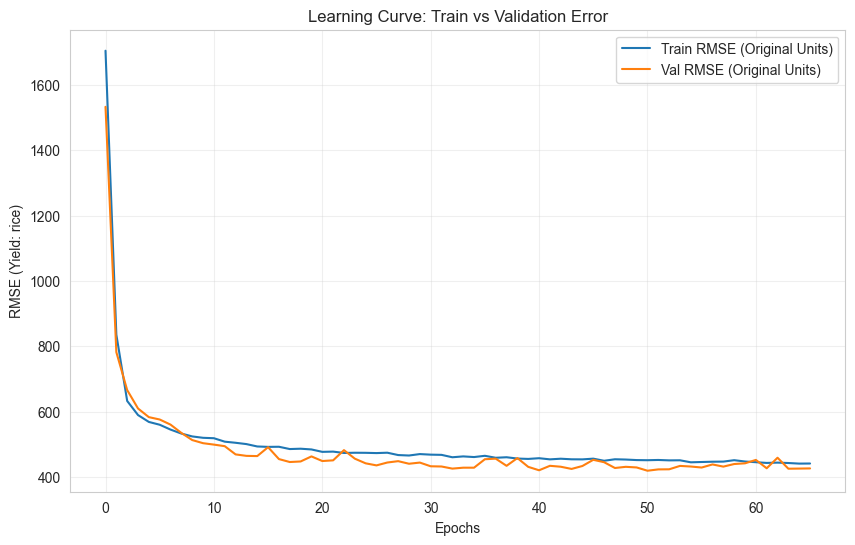

In [6]:
# ============================================================
# 2. MODEL DEFINITION (same as yours, but shape-consistent)
# ============================================================
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2, activation="ReLU"):
        super().__init__()
        
        # 1. LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        
        # 2. Output head: Linear -> Activation -> Linear
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            getattr(nn, activation)(),  # e.g. nn.ReLU(), nn.Tanh()
            nn.Linear(hidden_dim, 1),
        )
        
    def forward(self, x):
        # x: (batch, seq_len, features)
        out, _ = self.lstm(x)
        last_step_out = out[:, -1, :]    # (batch, hidden_dim)
        prediction = self.fc(last_step_out)  # (batch, 1)
        return prediction                # keep (batch, 1) to match y shape


# ============================================================
# 3. GET DATA LOADERS FROM DF
#    (df must already exist in your environment)
# ============================================================
train_loader, val_loader, test_loader, feature_cols, scaler_y = preprocess_and_build_loaders(
    df=df,
    chosen_crop=CHOSEN_CROP,
    target_col=TARGET_COL,
    seq_len=SEQ_LEN,
    batch_size=BATCH_SIZE,
    clip_quant=CLIP_QUANT,
)

# ============================================================
# 4. INITIALIZE MODEL, OPTIMIZER, LOSS
# ============================================================
model = LSTMRegressor(
    input_dim=len(feature_cols),
    hidden_dim=64,
    num_layers=2,
    dropout=0.2,
    activation="ReLU",
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

# ============================================================
# 5. TRAINING LOOP (with early stopping + RMSE tracking)
# ============================================================
best_rmse = float("inf")
best_weights = None
counter = 0

train_rmse_history = []  # RMSE in original units
val_rmse_history = []    # RMSE in original units

print(f"Starting training on {len(train_loader)} batches...")

for epoch in range(EPOCHS):
    # ---------- TRAIN ----------
    model.train()
    train_loss = 0.0

    for X_b, y_b in train_loader:
        X_b = X_b.to(device)
        y_b = y_b.to(device)  # (batch, 1)

        optimizer.zero_grad()
        pred = model(X_b)     # (batch, 1)
        loss = criterion(pred, y_b)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss_scaled = train_loss / max(len(train_loader), 1)
    train_rmse_scaled = np.sqrt(avg_train_loss_scaled)
    # Convert scaled RMSE to original units via scaler_y
    train_rmse_orig = train_rmse_scaled * scaler_y.scale_[0]
    train_rmse_history.append(train_rmse_orig)

    # ---------- VALIDATION ----------
    model.eval()
    val_preds = []
    val_trues = []

    with torch.no_grad():
        for X_b, y_b in val_loader:
            X_b = X_b.to(device)
            pred = model(X_b).cpu().numpy()      # (batch, 1)
            val_preds.append(pred)
            val_trues.append(y_b.numpy())        # (batch, 1)

    if val_preds:
        vp_scaled = np.concatenate(val_preds, axis=0)      # (N, 1)
        vt_scaled = np.concatenate(val_trues, axis=0)      # (N, 1)

        vp_inv = scaler_y.inverse_transform(vp_scaled)     # (N, 1)
        vt_inv = scaler_y.inverse_transform(vt_scaled)     # (N, 1)

        val_rmse = np.sqrt(mean_squared_error(vt_inv, vp_inv))
        val_rmse_history.append(val_rmse)

        print(f"Epoch {epoch+1:03d}: Train RMSE {train_rmse_orig:.4f} | Val RMSE {val_rmse:.4f}")

        # Early stopping based on Val RMSE
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_weights = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            if counter >= PATIENCE:
                print(f"Early stopping triggered at epoch {epoch+1}!")
                break
    else:
        print(f"Epoch {epoch+1:03d}: Train RMSE {train_rmse_orig:.4f} | Val RMSE N/A (no val sequences)")

print("Training finished.")

# ============================================================
# 6. PLOT TRAIN vs VAL RMSE (ORIGINAL UNITS)
# ============================================================
plt.figure(figsize=(10, 6))
plt.plot(train_rmse_history, label="Train RMSE (Original Units)")
plt.plot(val_rmse_history, label="Val RMSE (Original Units)")
plt.xlabel("Epochs")
plt.ylabel(f"RMSE (Yield: {CHOSEN_CROP})")
plt.title("Learning Curve: Train vs Validation Error")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Load best weights (if any)
if best_weights is not None:
    model.load_state_dict(best_weights)

In [7]:
# ============================================================
# 7. FINAL EVALUATION (TRAIN / VAL / TEST, ORIGINAL UNITS)
# ============================================================
def evaluate_loader(model, loader, scaler_y, split_name=""):
    """
    Evaluate model on a given loader:
    - Inverse-transforms y and predictions.
    - Returns RMSE, MAE, R2, preds, trues.
    """
    model.eval()
    preds_scaled = []
    trues_scaled = []

    with torch.no_grad():
        for X_b, y_b in loader:
            X_b = X_b.to(device)
            pred = model(X_b).cpu().numpy()  # (batch, 1)
            preds_scaled.append(pred)
            trues_scaled.append(y_b.numpy()) # (batch, 1)

    if not preds_scaled:
        print(f"[{split_name}] No sequences.")
        return np.nan, np.nan, np.nan, np.array([]), np.array([])

    preds_scaled = np.concatenate(preds_scaled, axis=0)   # (N, 1)
    trues_scaled = np.concatenate(trues_scaled, axis=0)   # (N, 1)

    preds = scaler_y.inverse_transform(preds_scaled).ravel()
    trues = scaler_y.inverse_transform(trues_scaled).ravel()

    rmse = np.sqrt(mean_squared_error(trues, preds))
    mae = mean_absolute_error(trues, preds)
    r2  = r2_score(trues, preds)

    print(f"[{split_name}] RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")
    return rmse, mae, r2, preds, trues


print("\n=== Final Evaluation ===")
train_rmse, train_mae, train_r2, _, _ = evaluate_loader(model, train_loader, scaler_y, split_name="Train")
val_rmse,   val_mae,   val_r2,   _, _ = evaluate_loader(model, val_loader,   scaler_y, split_name="Val")
test_rmse,  test_mae,  test_r2,  p_test, t_test = evaluate_loader(model, test_loader,  scaler_y, split_name="Test")


=== Final Evaluation ===
[Train] RMSE: 434.88 | MAE: 285.51 | R²: 0.9462
[Val] RMSE: 418.83 | MAE: 269.15 | R²: 0.9625
[Test] RMSE: 458.94 | MAE: 286.38 | R²: 0.9550


In [8]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

def preprocess_and_build_loaders(
    df: pd.DataFrame,
    chosen_crop: str,
    target_col: str,
    seq_len: int = 5,
    batch_size: int = 32,
    clip_quant: float = 0.01,
):
    """
    Full preprocessing + sequence-building pipeline for panel time series LSTM.
    Quiet version (no prints).
    """

    df_model = df.copy()

    # 1) Drop rows with NaN target
    df_model = df_model[~df_model[target_col].isna()].copy()

    # 1.5) Remove per-area min/max target rows as outliers
    if "area" not in df_model.columns:
        raise ValueError("'area' column not found in df for min/max removal")

    idx_min = df_model.groupby("area")[target_col].idxmin().values
    idx_max = df_model.groupby("area")[target_col].idxmax().values
    rows_to_drop = np.unique(np.concatenate([idx_min, idx_max]))
    df_model = df_model.loc[~df_model.index.isin(rows_to_drop)].reset_index(drop=True)

    # 2) Target & feature selection
    all_targets = [c for c in df_model.columns if c.startswith("Y_")]
    drop_other_targets = [c for c in all_targets if c != target_col]
    df_model = df_model.drop(columns=drop_other_targets)

    avg_yield_cols = [c for c in df_model.columns if c.startswith("avg_yield_")]
    chosen_prefix = f"avg_yield_{chosen_crop}_"
    keep_avg_yield = [c for c in avg_yield_cols if c.startswith(chosen_prefix)]
    drop_avg_yield = list(set(avg_yield_cols) - set(keep_avg_yield))
    df_model = df_model.drop(columns=drop_avg_yield)

    # 3) Add time features
    base_year = df_model["year"].min()
    df_model["year_index"] = df_model["year"] - base_year
    max_index = df_model["year_index"].max() if df_model["year_index"].max() > 0 else 1
    df_model["year_norm"] = df_model["year_index"] / max_index

    # 4) Sort for time consistency
    df_model = df_model.sort_values(["area", "year"]).reset_index(drop=True)

    # 5) Define feature columns
    feature_cols = [
        c
        for c in df_model.columns
        if c not in ["area", "year", target_col] and not c.startswith("Y_")
    ]

    # 6) Group-wise ffill/bfill for feature columns
    df_model[feature_cols] = (
        df_model.groupby("area", group_keys=False)[feature_cols]
        .apply(lambda g: g.ffill().bfill())
    )

    # 7) Time-based masks (on rows; for scaling only)
    train_mask_rows = df_model["year"] < 2014
    val_mask_rows   = (df_model["year"] >= 2014) & (df_model["year"] <= 2018)
    test_mask_rows  = df_model["year"] >= 2019

    # 8) Raw arrays + NaN imputation (train-mean)
    X_raw = df_model[feature_cols].values.astype(np.float32)
    y_raw = df_model[[target_col]].values.astype(np.float32)

    train_X = X_raw[train_mask_rows]
    train_mean = np.nanmean(train_X, axis=0)
    nan_inds = np.where(np.isnan(X_raw))
    X_raw[nan_inds] = np.take(train_mean, nan_inds[1])

    # 9) Outlier clipping (train-based quantiles)
    if clip_quant is not None and 0.0 < clip_quant < 0.5:
        train_X_no_nan = X_raw[train_mask_rows]
        q_low = np.quantile(train_X_no_nan, clip_quant, axis=0)
        q_high = np.quantile(train_X_no_nan, 1.0 - clip_quant, axis=0)

        for j in range(train_X_no_nan.shape[1]):
            if q_low[j] < q_high[j]:
                X_raw[:, j] = np.clip(X_raw[:, j], q_low[j], q_high[j])

    # 10) Scaling (fit only on train)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = X_raw.copy()
    y_scaled = y_raw.copy()

    X_scaled[train_mask_rows] = scaler_X.fit_transform(X_raw[train_mask_rows])
    X_scaled[val_mask_rows]   = scaler_X.transform(X_raw[val_mask_rows])
    X_scaled[test_mask_rows]  = scaler_X.transform(X_raw[test_mask_rows])

    y_scaled[train_mask_rows] = scaler_y.fit_transform(y_raw[train_mask_rows])
    y_scaled[val_mask_rows]   = scaler_y.transform(y_raw[val_mask_rows])
    y_scaled[test_mask_rows]  = scaler_y.transform(y_raw[test_mask_rows])

    # 11) Rebuild scaled DataFrame for sequences
    df_scaled = df_model[["area", "year"]].copy()
    df_scaled["target_scaled"] = y_scaled.reshape(-1)

    X_df = pd.DataFrame(X_scaled, columns=feature_cols, index=df_model.index)
    df_final = pd.concat([df_scaled, X_df], axis=1)

    # 12) Sequence building with split by TARGET YEAR
    def build_sequences_by_split(
        df_seq: pd.DataFrame,
        feat_cols: list,
        target_col_name: str,
        seq_len_inner: int,
    ):
        X_train_list, y_train_list = [], []
        X_val_list, y_val_list     = [], []
        X_test_list, y_test_list   = [], []

        for _, g in df_seq.groupby("area"):
            g = g.sort_values("year")
            feats = g[feat_cols].values.astype(np.float32)
            targs = g[target_col_name].values.astype(np.float32)
            years = g["year"].values

            if len(g) < seq_len_inner:
                continue

            # Sliding window: [t-seq_len+1 ... t] -> target at t
            for i in range(len(g) - seq_len_inner + 1):
                X_seq = feats[i : i + seq_len_inner]
                y_t   = targs[i + seq_len_inner - 1]
                y_yr  = years[i + seq_len_inner - 1]

                if y_yr < 2014:
                    X_train_list.append(X_seq)
                    y_train_list.append(y_t)
                elif 2014 <= y_yr <= 2018:
                    X_val_list.append(X_seq)
                    y_val_list.append(y_t)
                else:  # y_yr >= 2019
                    X_test_list.append(X_seq)
                    y_test_list.append(y_t)

        def to_array(x_list, y_list):
            if len(x_list) == 0:
                return (
                    np.empty((0, seq_len_inner, len(feat_cols)), dtype=np.float32),
                    np.empty((0,), dtype=np.float32),
                )
            X_arr = np.stack(x_list).astype(np.float32)
            y_arr = np.array(y_list, dtype=np.float32)
            return X_arr, y_arr

        X_tr, y_tr = to_array(X_train_list, y_train_list)
        X_v, y_v   = to_array(X_val_list, y_val_list)
        X_te, y_te = to_array(X_test_list, y_test_list)

        return X_tr, y_tr, X_v, y_v, X_te, y_te

    X_train, y_train, X_val, y_val, X_test, y_test = build_sequences_by_split(
        df_final,
        feature_cols,
        "target_scaled",
        seq_len,
    )

    # 13) Build PyTorch DataLoaders
    def make_loader(X, y, batch_size_inner: int, shuffle: bool):
        X_tensor = torch.from_numpy(X)  # (N, seq_len, num_features)
        y_tensor = torch.from_numpy(y).unsqueeze(-1)  # (N, 1)
        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=batch_size_inner, shuffle=shuffle)

    train_loader = make_loader(X_train, y_train, batch_size, shuffle=True)
    val_loader   = make_loader(X_val,   y_val,   batch_size, shuffle=False)
    test_loader  = make_loader(X_test,  y_test,  batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, feature_cols, scaler_y


[I 2025-12-09 16:58:17,013] A new study created in memory with name: LSTM_optuna
Best trial: 0. Best value: 505.491:   3%|▎         | 1/30 [00:29<14:04, 29.13s/it]

[I 2025-12-09 16:58:46,146] Trial 0 finished with value: 505.4909278364944 and parameters: {'hidden_dim': 32, 'num_layers': 3, 'dropout': 0.25734071993712265, 'activation': 'Tanh', 'lr': 7.165750271897941e-05, 'seq_len': 5}. Best is trial 0 with value: 505.4909278364944.


Best trial: 1. Best value: 433.12:   7%|▋         | 2/30 [00:48<10:52, 23.30s/it] 

[I 2025-12-09 16:59:05,357] Trial 1 finished with value: 433.1199314277744 and parameters: {'hidden_dim': 96, 'num_layers': 3, 'dropout': 0.138943174704159, 'activation': 'ReLU', 'lr': 0.00028155456606726635, 'seq_len': 6}. Best is trial 1 with value: 433.1199314277744.


c:\Users\Trin Uthaisang\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1890207749711503 and num_layers=1
  warnings.warn(
Best trial: 2. Best value: 426.116:  10%|█         | 3/30 [01:05<09:14, 20.53s/it]

[I 2025-12-09 16:59:22,587] Trial 2 finished with value: 426.1159246613532 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.1890207749711503, 'activation': 'ReLU', 'lr': 4.992702262888513e-05, 'seq_len': 4}. Best is trial 2 with value: 426.1159246613532.


Best trial: 2. Best value: 426.116:  13%|█▎        | 4/30 [01:38<11:03, 25.50s/it]

[I 2025-12-09 16:59:55,718] Trial 3 finished with value: 474.2200504512647 and parameters: {'hidden_dim': 32, 'num_layers': 3, 'dropout': 0.24691086115193744, 'activation': 'Tanh', 'lr': 9.463163927932358e-05, 'seq_len': 4}. Best is trial 2 with value: 426.1159246613532.


Best trial: 2. Best value: 426.116:  17%|█▋        | 5/30 [01:53<09:01, 21.66s/it]

[I 2025-12-09 17:00:10,575] Trial 4 finished with value: 440.04064087877157 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'dropout': 0.11694682624081182, 'activation': 'ReLU', 'lr': 0.00024917722556082577, 'seq_len': 4}. Best is trial 2 with value: 426.1159246613532.


Best trial: 2. Best value: 426.116:  20%|██        | 6/30 [01:54<05:48, 14.50s/it]

[I 2025-12-09 17:00:11,173] Trial 5 pruned. 


Best trial: 2. Best value: 426.116:  23%|██▎       | 7/30 [01:55<03:52, 10.10s/it]c:\Users\Trin Uthaisang\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.259974966357987 and num_layers=1
  warnings.warn(


[I 2025-12-09 17:00:12,212] Trial 6 pruned. 


Best trial: 2. Best value: 426.116:  27%|██▋       | 8/30 [01:58<02:54,  7.92s/it]

[I 2025-12-09 17:00:15,468] Trial 7 finished with value: 434.7478974934784 and parameters: {'hidden_dim': 96, 'num_layers': 1, 'dropout': 0.259974966357987, 'activation': 'Tanh', 'lr': 0.0004234935068484742, 'seq_len': 4}. Best is trial 2 with value: 426.1159246613532.


Best trial: 2. Best value: 426.116:  30%|███       | 9/30 [02:11<03:18,  9.45s/it]

[I 2025-12-09 17:00:28,266] Trial 8 finished with value: 434.422569337736 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.25781242988933223, 'activation': 'ReLU', 'lr': 0.0009607507273511527, 'seq_len': 4}. Best is trial 2 with value: 426.1159246613532.


Best trial: 2. Best value: 426.116:  33%|███▎      | 10/30 [02:11<02:13,  6.66s/it]c:\Users\Trin Uthaisang\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1848123117390799 and num_layers=1
  warnings.warn(


[I 2025-12-09 17:00:28,675] Trial 9 pruned. 


Best trial: 2. Best value: 426.116:  37%|███▋      | 11/30 [02:12<01:30,  4.74s/it]c:\Users\Trin Uthaisang\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15200096476003688 and num_layers=1
  warnings.warn(


[I 2025-12-09 17:00:29,084] Trial 10 pruned. 


Best trial: 2. Best value: 426.116:  40%|████      | 12/30 [02:12<01:01,  3.42s/it]

[I 2025-12-09 17:00:29,484] Trial 11 pruned. 


Best trial: 2. Best value: 426.116:  43%|████▎     | 13/30 [02:22<01:30,  5.31s/it]

[I 2025-12-09 17:00:39,125] Trial 12 finished with value: 427.78974099433475 and parameters: {'hidden_dim': 96, 'num_layers': 2, 'dropout': 0.1898517877443309, 'activation': 'ReLU', 'lr': 0.0004181237008252917, 'seq_len': 6}. Best is trial 2 with value: 426.1159246613532.


Best trial: 13. Best value: 425.009:  47%|████▋     | 14/30 [02:31<01:43,  6.46s/it]c:\Users\Trin Uthaisang\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.21441759640892652 and num_layers=1
  warnings.warn(


[I 2025-12-09 17:00:48,243] Trial 13 finished with value: 425.0090991673002 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.20505962452346008, 'activation': 'ReLU', 'lr': 0.0005596071513660981, 'seq_len': 6}. Best is trial 13 with value: 425.0090991673002.


Best trial: 13. Best value: 425.009:  50%|█████     | 15/30 [02:34<01:22,  5.53s/it]c:\Users\Trin Uthaisang\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.011221181181384404 and num_layers=1
  warnings.warn(


[I 2025-12-09 17:00:51,620] Trial 14 finished with value: 428.6502799485847 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.21441759640892652, 'activation': 'ReLU', 'lr': 0.0008263851410096589, 'seq_len': 5}. Best is trial 13 with value: 425.0090991673002.


Best trial: 13. Best value: 425.009:  53%|█████▎    | 16/30 [02:34<00:55,  3.98s/it]

[I 2025-12-09 17:00:51,994] Trial 15 pruned. 


Best trial: 13. Best value: 425.009:  57%|█████▋    | 17/30 [02:35<00:38,  2.95s/it]c:\Users\Trin Uthaisang\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.08111121916133901 and num_layers=1
  warnings.warn(


[I 2025-12-09 17:00:52,542] Trial 16 pruned. 


Best trial: 13. Best value: 425.009:  60%|██████    | 18/30 [02:35<00:26,  2.18s/it]

[I 2025-12-09 17:00:52,951] Trial 17 pruned. 


Best trial: 13. Best value: 425.009:  63%|██████▎   | 19/30 [02:36<00:18,  1.71s/it]c:\Users\Trin Uthaisang\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.22438498555494588 and num_layers=1
  warnings.warn(


[I 2025-12-09 17:00:53,560] Trial 18 pruned. 


Best trial: 19. Best value: 424.745:  67%|██████▋   | 20/30 [02:42<00:29,  2.94s/it]

[I 2025-12-09 17:00:59,353] Trial 19 finished with value: 424.74501542101706 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.22438498555494588, 'activation': 'ReLU', 'lr': 0.00062564983232481, 'seq_len': 4}. Best is trial 19 with value: 424.74501542101706.


Best trial: 19. Best value: 424.745:  70%|███████   | 21/30 [02:42<00:20,  2.22s/it]c:\Users\Trin Uthaisang\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.29646493051487405 and num_layers=1
  warnings.warn(


[I 2025-12-09 17:00:59,915] Trial 20 pruned. 


Best trial: 21. Best value: 420.716:  73%|███████▎  | 22/30 [02:49<00:27,  3.44s/it]c:\Users\Trin Uthaisang\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.27682007472857406 and num_layers=1
  warnings.warn(


[I 2025-12-09 17:01:06,186] Trial 21 finished with value: 420.71646479547246 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.29646493051487405, 'activation': 'ReLU', 'lr': 0.0006277952388251905, 'seq_len': 4}. Best is trial 21 with value: 420.71646479547246.


Best trial: 21. Best value: 420.716:  77%|███████▋  | 23/30 [02:52<00:23,  3.31s/it]c:\Users\Trin Uthaisang\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.29582153564510033 and num_layers=1
  warnings.warn(


[I 2025-12-09 17:01:09,198] Trial 22 finished with value: 430.3727490501693 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.27682007472857406, 'activation': 'ReLU', 'lr': 0.0006532981383269605, 'seq_len': 4}. Best is trial 21 with value: 420.71646479547246.


Best trial: 21. Best value: 420.716:  80%|████████  | 24/30 [02:52<00:14,  2.43s/it]c:\Users\Trin Uthaisang\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.21832432016606107 and num_layers=1
  warnings.warn(


[I 2025-12-09 17:01:09,584] Trial 23 pruned. 


Best trial: 24. Best value: 419.794:  83%|████████▎ | 25/30 [02:57<00:15,  3.10s/it]c:\Users\Trin Uthaisang\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2314597973111981 and num_layers=1
  warnings.warn(


[I 2025-12-09 17:01:14,243] Trial 24 finished with value: 419.7935876713697 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.21832432016606107, 'activation': 'ReLU', 'lr': 0.0006132991834750299, 'seq_len': 4}. Best is trial 24 with value: 419.7935876713697.


Best trial: 24. Best value: 419.794:  87%|████████▋ | 26/30 [02:57<00:09,  2.26s/it]c:\Users\Trin Uthaisang\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.22815137989190448 and num_layers=1
  warnings.warn(


[I 2025-12-09 17:01:14,557] Trial 25 pruned. 


Best trial: 24. Best value: 419.794:  90%|█████████ | 27/30 [03:04<00:10,  3.62s/it]c:\Users\Trin Uthaisang\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2713603180123211 and num_layers=1
  warnings.warn(


[I 2025-12-09 17:01:21,356] Trial 26 finished with value: 424.16850646293864 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.22815137989190448, 'activation': 'Tanh', 'lr': 0.0007236140009753902, 'seq_len': 4}. Best is trial 24 with value: 419.7935876713697.


Best trial: 24. Best value: 419.794:  93%|█████████▎| 28/30 [03:09<00:07,  3.99s/it]c:\Users\Trin Uthaisang\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17062089909358918 and num_layers=1
  warnings.warn(


[I 2025-12-09 17:01:26,209] Trial 27 finished with value: 427.18341713484153 and parameters: {'hidden_dim': 96, 'num_layers': 1, 'dropout': 0.2713603180123211, 'activation': 'Tanh', 'lr': 0.0009376327791451546, 'seq_len': 4}. Best is trial 24 with value: 419.7935876713697.


Best trial: 24. Best value: 419.794:  97%|█████████▋| 29/30 [03:09<00:02,  2.91s/it]c:\Users\Trin Uthaisang\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2435871820302738 and num_layers=1
  warnings.warn(


[I 2025-12-09 17:01:26,588] Trial 28 pruned. 


Best trial: 24. Best value: 419.794: 100%|██████████| 30/30 [03:09<00:00,  6.33s/it]
c:\Users\Trin Uthaisang\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.21832432016606107 and num_layers=1
  warnings.warn(


[I 2025-12-09 17:01:26,916] Trial 29 pruned. 
=== OPTUNA BEST RESULT ===
Best Val RMSE: 419.7935876713697
Best Params: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.21832432016606107, 'activation': 'ReLU', 'lr': 0.0006132991834750299, 'seq_len': 4}

=== Retraining final LSTM with best Optuna params ===
hidden_dim=64, num_layers=1, dropout=0.21832432016606107, activation=ReLU, lr=0.0006132991834750299, seq_len=4
[FINAL] Epoch 001: Train RMSE 1219.5794 | Val RMSE 637.8669
[FINAL] Epoch 002: Train RMSE 542.1545 | Val RMSE 524.8323
[FINAL] Epoch 003: Train RMSE 503.6129 | Val RMSE 489.7969
[FINAL] Epoch 004: Train RMSE 485.8724 | Val RMSE 461.5642
[FINAL] Epoch 005: Train RMSE 474.0285 | Val RMSE 472.4121
[FINAL] Epoch 006: Train RMSE 463.3629 | Val RMSE 444.0409
[FINAL] Epoch 007: Train RMSE 459.1555 | Val RMSE 452.8333
[FINAL] Epoch 008: Train RMSE 456.8450 | Val RMSE 438.7245
[FINAL] Epoch 009: Train RMSE 454.7820 | Val RMSE 437.4075
[FINAL] Epoch 010: Train RMSE 449.1402 | Val RMSE 

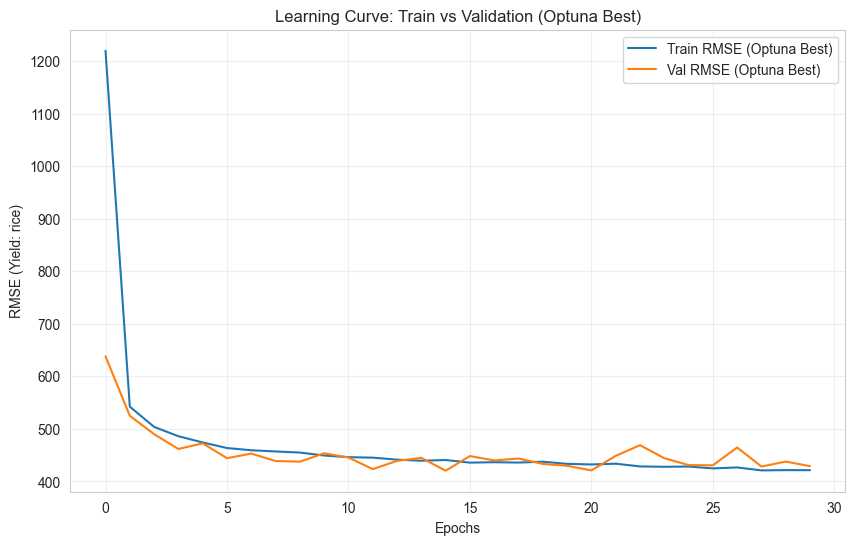


=== Final Evaluation: Optuna-Tuned LSTM ===
[Train (Optuna)] RMSE: 432.00 | MAE: 285.64 | R²: 0.9463
[Val (Optuna)] RMSE: 420.21 | MAE: 274.99 | R²: 0.9623
[Test (Optuna)] RMSE: 457.42 | MAE: 291.47 | R²: 0.9553


In [9]:
# ============================================================
# 8. OPTUNA TUNING FOR LSTM HYPERPARAMETERS
# ============================================================
import optuna

def objective(trial):
    """
    Optuna objective function:
    - Suggests LSTM + training hyperparameters
    - Rebuilds dataloaders with suggested seq_len
    - Trains on train set, evaluates on val set
    - Returns best validation RMSE (original units)
    """

    # ---- Hyperparameters to tune ----
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128, step=32)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    activation = trial.suggest_categorical("activation", ["ReLU", "Tanh"])
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    seq_len = trial.suggest_int("seq_len", 4, 6)

    # ---- Build loaders for this seq_len ----
    train_loader_opt, val_loader_opt, test_loader_opt, feature_cols_opt, scaler_y_opt = preprocess_and_build_loaders(
        df=df,
        chosen_crop=CHOSEN_CROP,
        target_col=TARGET_COL,
        seq_len=seq_len,
        batch_size=BATCH_SIZE,
        clip_quant=CLIP_QUANT,
    )

    # If val set is empty for this seq_len, return large loss
    if len(val_loader_opt.dataset) == 0 or len(train_loader_opt.dataset) == 0:
        return float("inf")

    # ---- Build model for this trial ----
    model_opt = LSTMRegressor(
        input_dim=len(feature_cols_opt),
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout,
        activation=activation,
    ).to(device)

    optimizer_opt = torch.optim.Adam(model_opt.parameters(), lr=lr)
    criterion_opt = nn.MSELoss()

    max_epochs = 80     # you can increase later
    patience = 5
    best_val_rmse = float("inf")
    counter = 0

    for epoch in range(max_epochs):
        # ---------- TRAIN ----------
        model_opt.train()
        train_loss = 0.0

        for X_b, y_b in train_loader_opt:
            X_b, y_b = X_b.to(device), y_b.to(device)
            optimizer_opt.zero_grad()
            pred = model_opt(X_b)
            loss = criterion_opt(pred, y_b)
            loss.backward()
            optimizer_opt.step()
            train_loss += loss.item()

        # ---------- VALIDATION ----------
        model_opt.eval()
        val_preds_scaled, val_trues_scaled = [], []
        with torch.no_grad():
            for X_b, y_b in val_loader_opt:
                X_b = X_b.to(device)
                pred = model_opt(X_b).cpu().numpy()
                val_preds_scaled.append(pred)
                val_trues_scaled.append(y_b.numpy())

        if not val_preds_scaled:
            # no val batches
            return float("inf")

        vp_scaled = np.concatenate(val_preds_scaled, axis=0).reshape(-1, 1)
        vt_scaled = np.concatenate(val_trues_scaled, axis=0).reshape(-1, 1)

        # inverse transform to original units
        vp_inv = scaler_y_opt.inverse_transform(vp_scaled)
        vt_inv = scaler_y_opt.inverse_transform(vt_scaled)

        val_rmse = np.sqrt(mean_squared_error(vt_inv, vp_inv))

        # early stopping inside a trial
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break

        # report to Optuna (for pruning)
        trial.report(best_val_rmse, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_val_rmse


# ============================================================
# 9. RUN OPTUNA STUDY
# ============================================================
study = optuna.create_study(
    direction="minimize",
    study_name="LSTM_optuna",
)
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("=== OPTUNA BEST RESULT ===")
print("Best Val RMSE:", study.best_value)
print("Best Params:", study.best_params)


# ============================================================
# 10. TRAIN FINAL MODEL WITH BEST HYPERPARAMETERS
# ============================================================
best_params = study.best_params

best_hidden_dim = best_params["hidden_dim"]
best_num_layers = best_params["num_layers"]
best_dropout = best_params["dropout"]
best_activation = best_params["activation"]
best_lr = best_params["lr"]
best_seq_len = best_params["seq_len"]

print("\n=== Retraining final LSTM with best Optuna params ===")
print(f"hidden_dim={best_hidden_dim}, num_layers={best_num_layers}, "
      f"dropout={best_dropout}, activation={best_activation}, "
      f"lr={best_lr}, seq_len={best_seq_len}")

# Rebuild loaders with best seq_len
train_loader_opt, val_loader_opt, test_loader_opt, feature_cols_opt, scaler_y_opt = preprocess_and_build_loaders(
    df=df,
    chosen_crop=CHOSEN_CROP,
    target_col=TARGET_COL,
    seq_len=best_seq_len,
    batch_size=BATCH_SIZE,
    clip_quant=CLIP_QUANT,
)

# Define final model
final_model = LSTMRegressor(
    input_dim=len(feature_cols_opt),
    hidden_dim=best_hidden_dim,
    num_layers=best_num_layers,
    dropout=best_dropout,
    activation=best_activation,
).to(device)

optimizer_final = torch.optim.Adam(final_model.parameters(), lr=best_lr)
criterion_final = nn.MSELoss()

best_rmse_final = float("inf")
best_weights_final = None
counter_final = 0

EPOCHS_FINAL = 100
PATIENCE_FINAL = 15

train_rmse_hist_final = []
val_rmse_hist_final = []

for epoch in range(EPOCHS_FINAL):
    # ---------- TRAIN ----------
    final_model.train()
    train_loss = 0.0
    for X_b, y_b in train_loader_opt:
        X_b, y_b = X_b.to(device), y_b.to(device)
        optimizer_final.zero_grad()
        pred = final_model(X_b)
        loss = criterion_final(pred, y_b)
        loss.backward()
        optimizer_final.step()
        train_loss += loss.item()

    avg_train_loss_scaled = train_loss / max(len(train_loader_opt), 1)
    train_rmse_scaled = np.sqrt(avg_train_loss_scaled)
    train_rmse_orig = train_rmse_scaled * scaler_y_opt.scale_[0]
    train_rmse_hist_final.append(train_rmse_orig)

    # ---------- VALIDATION ----------
    final_model.eval()
    val_preds_scaled, val_trues_scaled = [], []
    with torch.no_grad():
        for X_b, y_b in val_loader_opt:
            X_b = X_b.to(device)
            pred = final_model(X_b).cpu().numpy()
            val_preds_scaled.append(pred)
            val_trues_scaled.append(y_b.numpy())

    if val_preds_scaled:
        vp_scaled = np.concatenate(val_preds_scaled, axis=0).reshape(-1, 1)
        vt_scaled = np.concatenate(val_trues_scaled, axis=0).reshape(-1, 1)

        vp_inv = scaler_y_opt.inverse_transform(vp_scaled)
        vt_inv = scaler_y_opt.inverse_transform(vt_scaled)

        val_rmse = np.sqrt(mean_squared_error(vt_inv, vp_inv))
        val_rmse_hist_final.append(val_rmse)

        print(f"[FINAL] Epoch {epoch+1:03d}: Train RMSE {train_rmse_orig:.4f} | Val RMSE {val_rmse:.4f}")

        if val_rmse < best_rmse_final:
            best_rmse_final = val_rmse
            best_weights_final = copy.deepcopy(final_model.state_dict())
            counter_final = 0
        else:
            counter_final += 1
            if counter_final >= PATIENCE_FINAL:
                print(f"[FINAL] Early stopping at epoch {epoch+1}")
                break
    else:
        print(f"[FINAL] Epoch {epoch+1:03d}: Train RMSE {train_rmse_orig:.4f} | Val RMSE N/A")

print("Final training with best Optuna params completed.")

# Load best weights
if best_weights_final is not None:
    final_model.load_state_dict(best_weights_final)

# Plot final learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_rmse_hist_final, label="Train RMSE (Optuna Best)")
plt.plot(val_rmse_hist_final, label="Val RMSE (Optuna Best)")
plt.xlabel("Epochs")
plt.ylabel(f"RMSE (Yield: {CHOSEN_CROP})")
plt.title("Learning Curve: Train vs Validation (Optuna Best)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ============================================================
# 11. EVALUATE FINAL MODEL (TRAIN / VAL / TEST)
# ============================================================
print("\n=== Final Evaluation: Optuna-Tuned LSTM ===")
_ = evaluate_loader(final_model, train_loader_opt, scaler_y_opt, split_name="Train (Optuna)")
_ = evaluate_loader(final_model, val_loader_opt,   scaler_y_opt, split_name="Val (Optuna)")
_ = evaluate_loader(final_model, test_loader_opt,  scaler_y_opt, split_name="Test (Optuna)")


In [10]:
# Optuna Visualizations
name = f"{CHOSEN_CROP.capitalize()}_Yield_LSTM"

# 1. Optimization History (best value over trials)
fig = plot_optimization_history(study)
fig.update_layout(
    title=f"{name} – Optimization History (Val RMSE)",
    xaxis_title="Trial",
    yaxis_title="Best Val RMSE",
    width=900,
    height=500,
)
fig.show()

# 2. Parallel Coordinate Plot (how hyperparams interact)
fig = plot_parallel_coordinate(study)
fig.update_layout(
    title=f"{name} – Parallel Coordinate Plot",
    width=900,
    height=500,
)
fig.show()

# 3. Slice Plot (effect of each hyperparameter individually)
fig = plot_slice(study)
fig.update_layout(
    title=f"{name} – Slice Plot",
    width=900,
    height=500,
)
fig.show()

# 4. Hyperparameter Importance (which params matter most)
try:
    fig = plot_param_importances(study)
    fig.update_layout(
        title=f"{name} – Hyperparameter Importance",
        width=900,
        height=500,
    )
    fig.show()
except (ValueError, RuntimeError) as e:
    print(f"Could not plot parameter importance: {e}")

[Test (Initial LSTM)] RMSE: 458.94 | MAE: 286.38 | R²: 0.9550
[Test (Optuna LSTM)] RMSE: 457.42 | MAE: 291.47 | R²: 0.9553

--- Final LSTM Performance Report (Test Set) ---
Baseline Model:   RMSE=536.79, R2=0.9417
Initial LSTM:     RMSE=458.94, R2=0.9550
Tuned LSTM (Opt): RMSE=457.42, R2=0.9553 (RMSE Improved 14.78%)


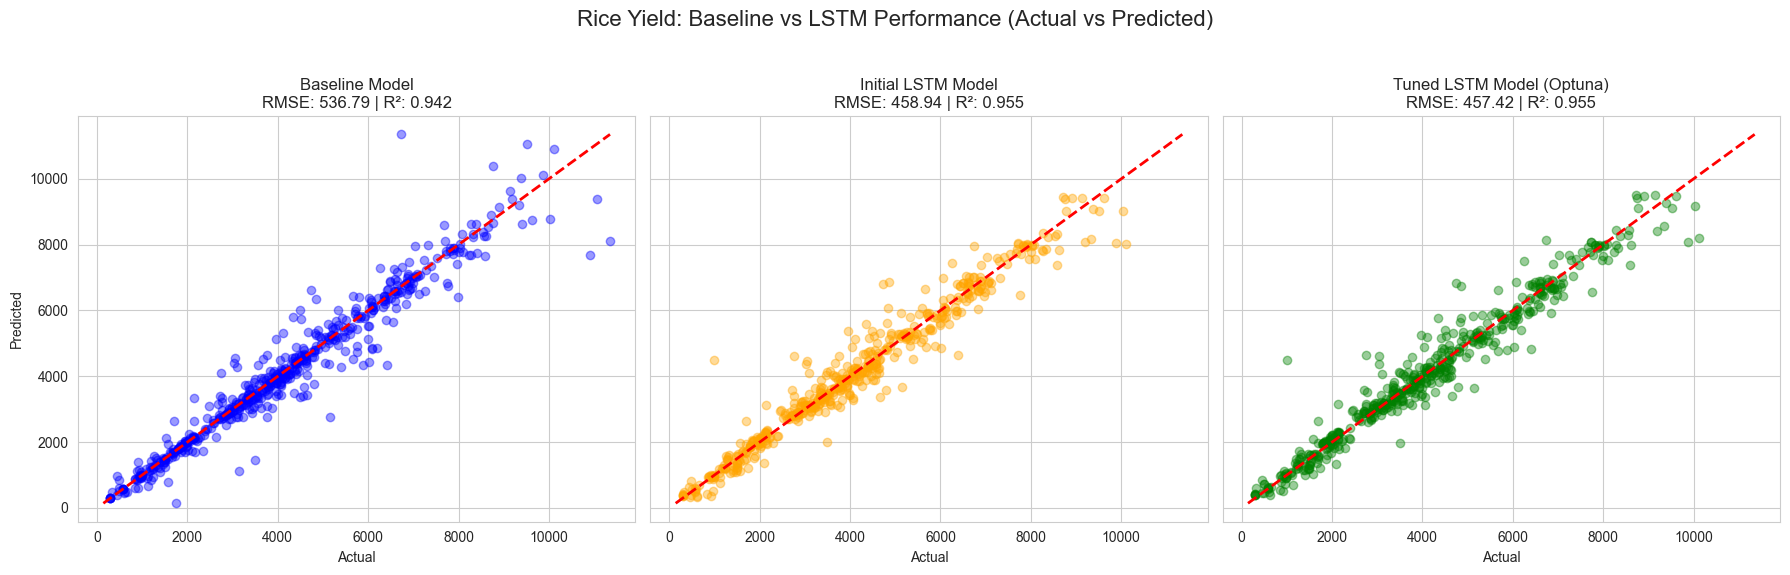

In [11]:
# ============================================================
# EVALUATE INITIAL LSTM & OPTUNA-TUNED LSTM ON TEST SET
# ============================================================

# Initial LSTM (before Optuna)
rmse_lstm_init, mae_lstm_init, r2_lstm_init, y_pred_lstm_init, y_true_lstm_init = evaluate_loader(
    model,                # initial LSTM
    test_loader,
    scaler_y,
    split_name="Test (Initial LSTM)"
)

# Optuna-tuned LSTM (final_model)
rmse_lstm_opt, mae_lstm_opt, r2_lstm_opt, y_pred_lstm_opt, y_true_lstm_opt = evaluate_loader(
    final_model,          # tuned LSTM
    test_loader_opt,
    scaler_y_opt,
    split_name="Test (Optuna LSTM)"
)

# ============================================================
# PERFORMANCE REPORT vs BASELINE
# ============================================================
imp_final_lstm = (rmse_baseline - rmse_lstm_opt) / rmse_baseline * 100

print("\n--- Final LSTM Performance Report (Test Set) ---")
print(f"Baseline Model:   RMSE={rmse_baseline:.2f}, R2={r2_baseline:.4f}")
print(f"Initial LSTM:     RMSE={rmse_lstm_init:.2f}, R2={r2_lstm_init:.4f}")
print(f"Tuned LSTM (Opt): RMSE={rmse_lstm_opt:.2f}, R2={r2_lstm_opt:.4f} "
      f"(RMSE Improved {imp_final_lstm:.2f}%)")

# ============================================================
# PLOTTING: BASELINE vs INITIAL LSTM vs TUNED LSTM
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Flatten everything
y_base_true  = np.ravel(y_test_clean)
y_base_pred  = np.ravel(y_pred_clean)

y_init_true  = np.ravel(y_true_lstm_init)
y_init_pred  = np.ravel(y_pred_lstm_init)

y_opt_true   = np.ravel(y_true_lstm_opt)
y_opt_pred   = np.ravel(y_pred_lstm_opt)

# Axis limits based on all predictions and truths
all_preds = np.concatenate([y_base_pred, y_init_pred, y_opt_pred])
all_true  = np.concatenate([y_base_true, y_init_true, y_opt_true])

min_val = min(all_preds.min(), all_true.min())
max_val = max(all_preds.max(), all_true.max())

# 1. Baseline Plot
axes[0].scatter(y_base_true, y_base_pred, alpha=0.4, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_title(f'Baseline Model\nRMSE: {rmse_baseline:.2f} | R²: {r2_baseline:.3f}')
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted")

# 2. Initial LSTM Plot
axes[1].scatter(y_init_true, y_init_pred, alpha=0.4, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1].set_title(f'Initial LSTM Model\nRMSE: {rmse_lstm_init:.2f} | R²: {r2_lstm_init:.3f}')
axes[1].set_xlabel("Actual")

# 3. Tuned LSTM Plot
axes[2].scatter(y_opt_true, y_opt_pred, alpha=0.4, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[2].set_title(f'Tuned LSTM Model (Optuna)\nRMSE: {rmse_lstm_opt:.2f} | R²: {r2_lstm_opt:.3f}')
axes[2].set_xlabel("Actual")

plt.suptitle(f'{CHOSEN_CROP.capitalize()} Yield: Baseline vs LSTM Performance (Actual vs Predicted)',
             fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


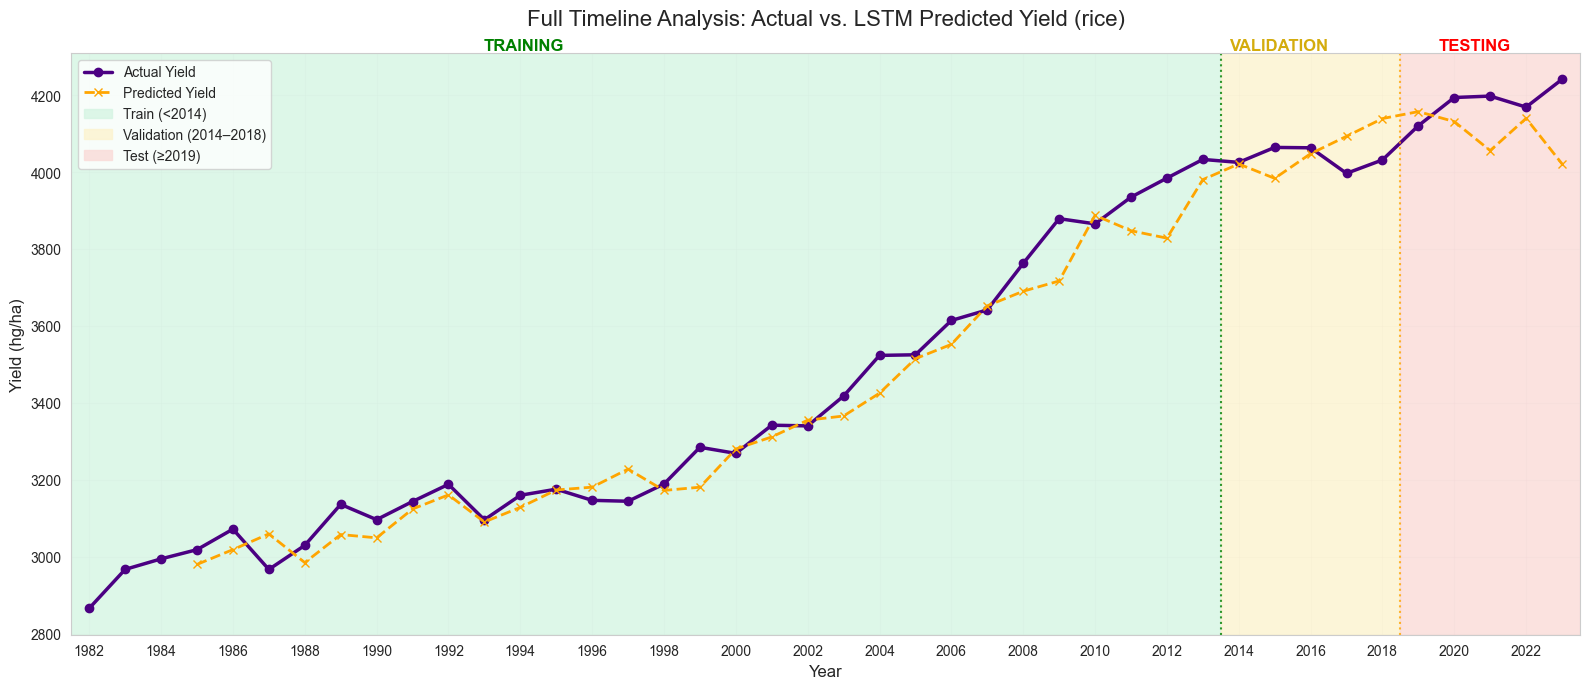

In [12]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

TRAIN_END_YEAR = 2014
VAL_END_YEAR   = 2019   # test starts at 2019    # batch size for ordered loaders (no shuffle)

# ------------------------------------------------
# 1) Ordered loaders (NO SHUFFLE) from Optuna data
# ------------------------------------------------
train_loader_ordered = DataLoader(train_loader_opt.dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader_ordered   = DataLoader(val_loader_opt.dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader_ordered  = DataLoader(test_loader_opt.dataset,  batch_size=BATCH_SIZE, shuffle=False)

# ------------------------------------------------
# 2) Helper: get true & pred in ORIGINAL units
# ------------------------------------------------
def get_true_pred_arrays(model, loader, scaler_y):
    model.eval()
    preds_scaled, trues_scaled = [], []
    with torch.no_grad():
        for X_b, y_b in loader:
            X_b = X_b.to(device)
            pred = model(X_b).cpu().numpy()        # (batch, 1)
            preds_scaled.append(pred)
            trues_scaled.append(y_b.numpy())      # (batch, 1)

    preds_scaled = np.concatenate(preds_scaled, axis=0).reshape(-1, 1)
    trues_scaled = np.concatenate(trues_scaled, axis=0).reshape(-1, 1)

    preds = scaler_y.inverse_transform(preds_scaled).flatten()
    trues = scaler_y.inverse_transform(trues_scaled).flatten()
    return trues, preds

# ------------------------------------------------
# 3) Build sequence YEARS in the same way as training
#    (drop NaN, remove min/max per area, keep chosen crop cols)
# ------------------------------------------------
def build_sequence_years_for_optuna(df, seq_len):
    df_model = df.copy()
    df_model = df_model[~df_model[TARGET_COL].isna()].copy()

    # remove per-area min/max outliers (same as in preprocess)
    if "area" not in df_model.columns:
        raise ValueError("'area' column not found in df for min/max removal")

    idx_min = df_model.groupby("area")[TARGET_COL].idxmin().values
    idx_max = df_model.groupby("area")[TARGET_COL].idxmax().values
    rows_to_drop = np.unique(np.concatenate([idx_min, idx_max]))
    df_model = df_model.loc[~df_model.index.isin(rows_to_drop)].reset_index(drop=True)

    # keep only this target & its avg_yield_* features (structure only)
    all_targets = [c for c in df_model.columns if c.startswith("Y_")]
    df_model = df_model.drop(columns=[c for c in all_targets if c != TARGET_COL])

    avg_yield_cols = [c for c in df_model.columns if c.startswith("avg_yield_")]
    chosen_prefix = f"avg_yield_{CHOSEN_CROP}_"
    keep_avg = [c for c in avg_yield_cols if c.startswith(chosen_prefix)]
    drop_avg = list(set(avg_yield_cols) - set(keep_avg))
    df_model = df_model.drop(columns=drop_avg)

    df_model = df_model.sort_values(["area", "year"]).reset_index(drop=True)

    seq_years_train, seq_years_val, seq_years_test = [], [], []

    for _, g in df_model.groupby("area"):
        g = g.sort_values("year")
        years = g["year"].values
        if len(g) < seq_len:
            continue

        for i in range(len(g) - seq_len + 1):
            yr = years[i + seq_len - 1]  # target year = last year in window
            if yr < TRAIN_END_YEAR:
                seq_years_train.append(yr)
            elif yr < VAL_END_YEAR:
                seq_years_val.append(yr)
            else:
                seq_years_test.append(yr)

    return (np.array(seq_years_train, dtype=int),
            np.array(seq_years_val,   dtype=int),
            np.array(seq_years_test,  dtype=int))

# ------------------------------------------------
# 4) Get true & predicted values from tuned LSTM
# ------------------------------------------------
y_train_true_opt, y_train_pred_opt = get_true_pred_arrays(final_model, train_loader_ordered, scaler_y_opt)
y_val_true_opt,   y_val_pred_opt   = get_true_pred_arrays(final_model, val_loader_ordered,   scaler_y_opt)
y_test_true_opt,  y_test_pred_opt  = get_true_pred_arrays(final_model, test_loader_ordered,  scaler_y_opt)

# ------------------------------------------------
# 5) Target YEARS for each sequence
# ------------------------------------------------
seq_years_train_opt, seq_years_val_opt, seq_years_test_opt = build_sequence_years_for_optuna(
    df=df,
    seq_len=best_seq_len,
)

# sanity checks
assert len(seq_years_train_opt) == len(y_train_true_opt)
assert len(seq_years_val_opt)   == len(y_val_true_opt)
assert len(seq_years_test_opt)  == len(y_test_true_opt)

# ------------------------------------------------
# 6) Build yearly LSTM prediction timeline
# ------------------------------------------------
df_full_trend = pd.DataFrame({
    "Year": np.concatenate([seq_years_train_opt, seq_years_val_opt, seq_years_test_opt]),
    "Predicted": np.concatenate([y_train_pred_opt, y_val_pred_opt, y_test_pred_opt])
})

# actual yearly yield from raw df
yearly_actual = (
    df
    .groupby("year")[TARGET_COL]
    .mean()
    .rename("Actual")
)

# predicted yearly yield from LSTM
yearly_pred = (
    df_full_trend
    .groupby("Year")["Predicted"]
    .mean()
    .rename("Predicted")
)

yearly_timeline = (
    pd.concat([yearly_actual, yearly_pred], axis=1)
      .rename_axis("Year")
      .reset_index()
      .sort_values("Year")
)

yearly_timeline["Year"] = yearly_timeline["Year"].astype(int)

MIN_YEAR = int(yearly_timeline["Year"].min())
MAX_YEAR = int(yearly_timeline["Year"].max())

train_boundary = TRAIN_END_YEAR - 0.5
val_boundary   = VAL_END_YEAR   - 0.5

# ------------------------------------------------
# 7) Plot timeline: Actual vs LSTM (Train / Val / Test)
# ------------------------------------------------
plt.figure(figsize=(16, 7))
ax = plt.gca()

# Actual yield
ax.plot(
    yearly_timeline["Year"], yearly_timeline["Actual"],
    marker="o", linewidth=2.5,
    color="#4B0082",
    label="Actual Yield"
)

# LSTM predicted yield
ax.plot(
    yearly_timeline["Year"], yearly_timeline["Predicted"],
    marker="x", linestyle="--", linewidth=2.0,
    color="#FFA500",
    label="Predicted Yield"
)

# Shaded regions
ax.axvspan(MIN_YEAR - 0.5, train_boundary,
           color="#D5F5E3", alpha=0.8, label="Train (<2014)")
ax.axvspan(train_boundary, val_boundary,
           color="#FCF3CF", alpha=0.8, label="Validation (2014–2018)")
ax.axvspan(val_boundary, MAX_YEAR + 0.5,
           color="#FADBD8", alpha=0.8, label="Test (≥2019)")

# Split lines
ax.axvline(train_boundary, color="green",  linestyle=":", linewidth=1.5, alpha=0.8)
ax.axvline(val_boundary,   color="orange", linestyle=":", linewidth=1.5, alpha=0.8)

# Labels at top
ax.text(0.30, 1.00, "TRAINING",
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=12, fontweight="bold", color="green")
ax.text(0.80, 1.00, "VALIDATION",
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=12, fontweight="bold", color="#D4AC0D")
ax.text(0.93, 1.00, "TESTING",
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=12, fontweight="bold", color="red")

ax.set_title(f"Full Timeline Analysis: Actual vs. LSTM Predicted Yield ({CHOSEN_CROP})",
             fontsize=16, pad=20)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Yield (hg/ha)", fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xticks(np.arange(MIN_YEAR, MAX_YEAR + 1, 2))
ax.set_xlim(MIN_YEAR - 0.5, MAX_YEAR + 0.5)

ax.legend(loc="upper left", frameon=True)
plt.tight_layout()
plt.show()


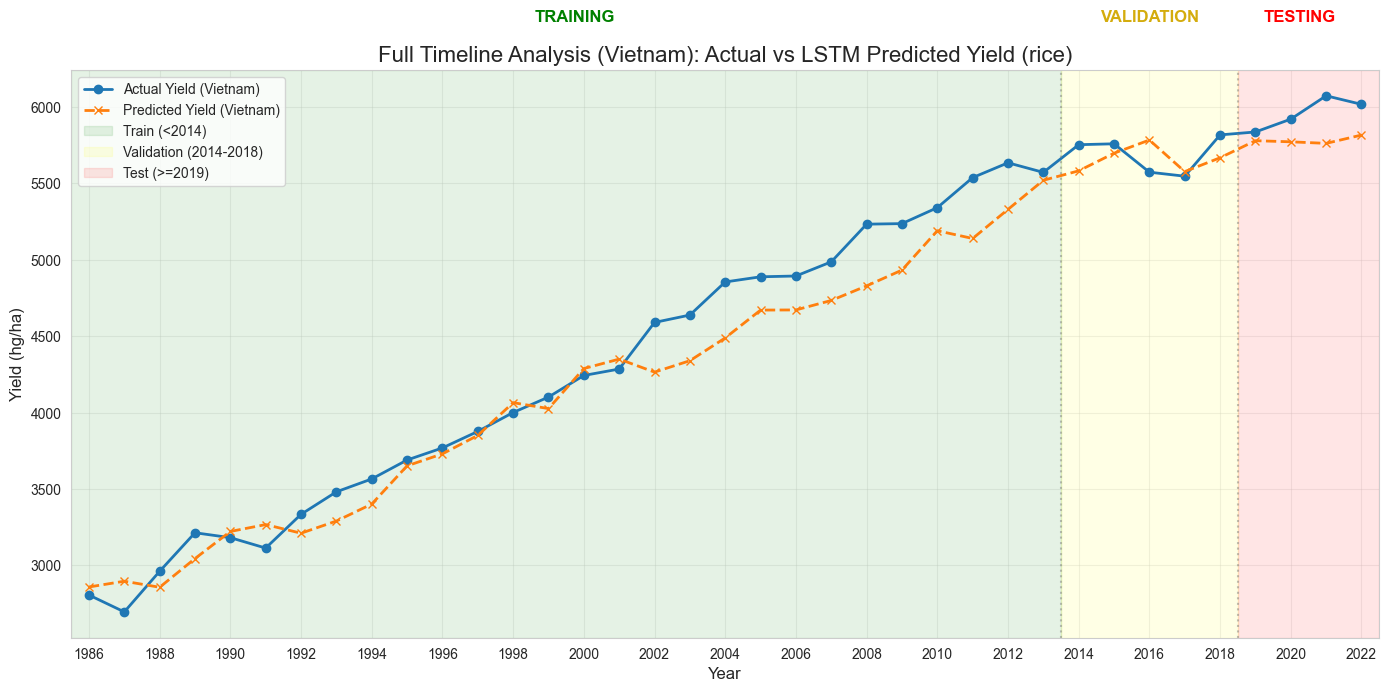

In [14]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

TRAIN_END_YEAR = 2014
VAL_END_YEAR   = 2019

# Country you want to plot
TARGET_COUNTRY = "Vietnam"

# -----------------------------
# 1) Ordered loaders (no shuffle)
# -----------------------------
train_loader_ordered = DataLoader(train_loader_opt.dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader_ordered   = DataLoader(val_loader_opt.dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader_ordered  = DataLoader(test_loader_opt.dataset,  batch_size=BATCH_SIZE, shuffle=False)

# -----------------------------
# 2) Helper: get true & pred in ORIGINAL units from LSTM
# -----------------------------
def get_true_pred_arrays(model, loader, scaler_y):
    model.eval()
    preds_scaled, trues_scaled = [], []
    with torch.no_grad():
        for X_b, y_b in loader:
            X_b = X_b.to(device)
            pred = model(X_b).cpu().numpy()   # (batch, 1)
            preds_scaled.append(pred)
            trues_scaled.append(y_b.numpy()) # (batch, 1)

    preds_scaled = np.concatenate(preds_scaled, axis=0).reshape(-1, 1)
    trues_scaled = np.concatenate(trues_scaled, axis=0).reshape(-1, 1)

    preds = scaler_y.inverse_transform(preds_scaled).ravel()
    trues = scaler_y.inverse_transform(trues_scaled).ravel()
    return trues, preds

# -----------------------------
# 3) Build (Area, Year) per sequence, same cleaning as preprocess
# -----------------------------
def build_sequence_meta_for_optuna(df, seq_len):
    df_model = df.copy()
    df_model = df_model[~df_model[TARGET_COL].isna()].copy()

    # remove per-area min/max outliers (like your preprocess)
    if "area" not in df_model.columns:
        raise ValueError("'area' column not found in df for min/max removal")

    idx_min = df_model.groupby("area")[TARGET_COL].idxmin().values
    idx_max = df_model.groupby("area")[TARGET_COL].idxmax().values
    rows_to_drop = np.unique(np.concatenate([idx_min, idx_max]))
    df_model = df_model.loc[~df_model.index.isin(rows_to_drop)].reset_index(drop=True)

    # keep only this target & its avg_yield features (shape only, not for scaling)
    all_targets = [c for c in df_model.columns if c.startswith("Y_")]
    df_model = df_model.drop(columns=[c for c in all_targets if c != TARGET_COL])

    avg_yield_cols = [c for c in df_model.columns if c.startswith("avg_yield_")]
    chosen_prefix = f"avg_yield_{CHOSEN_CROP}_"
    keep_avg = [c for c in avg_yield_cols if c.startswith(chosen_prefix)]
    drop_avg = list(set(avg_yield_cols) - set(keep_avg))
    df_model = df_model.drop(columns=drop_avg)

    # sort same as in preprocess
    df_model = df_model.sort_values(["area", "year"]).reset_index(drop=True)

    seq_areas_train, seq_years_train = [], []
    seq_areas_val,   seq_years_val   = [], []
    seq_areas_test,  seq_years_test  = [], []

    for area_name, g in df_model.groupby("area"):
        g = g.sort_values("year")
        years = g["year"].values
        if len(g) < seq_len:
            continue

        # sliding window, target at last year in window
        for i in range(len(g) - seq_len + 1):
            yr = years[i + seq_len - 1]
            if yr < TRAIN_END_YEAR:
                seq_areas_train.append(area_name)
                seq_years_train.append(yr)
            elif yr < VAL_END_YEAR:
                seq_areas_val.append(area_name)
                seq_years_val.append(yr)
            else:
                seq_areas_test.append(area_name)
                seq_years_test.append(yr)

    return (
        np.array(seq_areas_train),
        np.array(seq_years_train, dtype=int),
        np.array(seq_areas_val),
        np.array(seq_years_val,   dtype=int),
        np.array(seq_areas_test),
        np.array(seq_years_test,  dtype=int),
        df_model,   # cleaned df for actuals
    )

# -----------------------------
# 4) Get LSTM predictions for train/val/test
# -----------------------------
y_train_true_opt, y_train_pred_opt = get_true_pred_arrays(final_model, train_loader_ordered, scaler_y_opt)
y_val_true_opt,   y_val_pred_opt   = get_true_pred_arrays(final_model, val_loader_ordered,   scaler_y_opt)
y_test_true_opt,  y_test_pred_opt  = get_true_pred_arrays(final_model, test_loader_ordered,  scaler_y_opt)

# -----------------------------
# 5) Map each sequence to (Area, Year)
# -----------------------------
(
    seq_areas_train_opt,
    seq_years_train_opt,
    seq_areas_val_opt,
    seq_years_val_opt,
    seq_areas_test_opt,
    seq_years_test_opt,
    df_clean_for_actual,
) = build_sequence_meta_for_optuna(df=df, seq_len=best_seq_len)

# sanity checks
assert len(seq_years_train_opt) == len(y_train_true_opt)
assert len(seq_years_val_opt)   == len(y_val_true_opt)
assert len(seq_years_test_opt)  == len(y_test_true_opt)

assert len(seq_areas_train_opt) == len(y_train_true_opt)
assert len(seq_areas_val_opt)   == len(y_val_true_opt)
assert len(seq_areas_test_opt)  == len(y_test_true_opt)

# -----------------------------
# 6) Build df_full_trend (Area, Year, Actual, Predicted) like your example
# -----------------------------
# sequence-level predictions
df_pred = pd.DataFrame({
    "Area": np.concatenate([seq_areas_train_opt,  seq_areas_val_opt,  seq_areas_test_opt]),
    "Year": np.concatenate([seq_years_train_opt, seq_years_val_opt,  seq_years_test_opt]),
    "Predicted": np.concatenate([y_train_pred_opt, y_val_pred_opt, y_test_pred_opt])
})

# actual yields per Area-Year from cleaned df
df_actual = (
    df_clean_for_actual
    .groupby(["area", "year"])[TARGET_COL]
    .mean()
    .reset_index()
    .rename(columns={"area": "Area", "year": "Year", TARGET_COL: "Actual"})
)

# merge to get a structure similar to your df_full_trend
df_full_trend = df_pred.merge(df_actual, on=["Area", "Year"], how="left")

# -----------------------------
# 7) Filter for TARGET_COUNTRY and aggregate by Year
# -----------------------------
df_th = df_full_trend[df_full_trend["Area"] == TARGET_COUNTRY].copy()

yearly_trend = (
    df_th
    .groupby("Year")[["Actual", "Predicted"]]
    .mean()
)

if yearly_trend.empty:
    print(f"No data for {TARGET_COUNTRY}")
else:
    # -----------------------------
    # 8) Plot (same style as your example)
    # -----------------------------
    plt.figure(figsize=(14, 7))

    # Lines
    plt.plot(
        yearly_trend.index, yearly_trend["Actual"],
        marker="o", label=f"Actual Yield ({TARGET_COUNTRY})", linewidth=2
    )
    plt.plot(
        yearly_trend.index, yearly_trend["Predicted"],
        marker="x", linestyle="--", label=f"Predicted Yield ({TARGET_COUNTRY})", linewidth=2
    )

    MIN_YEAR = int(yearly_trend.index.min())
    MAX_YEAR = int(yearly_trend.index.max())

    train_boundary = TRAIN_END_YEAR - 0.5
    val_boundary   = VAL_END_YEAR   - 0.5

    # Shaded regions
    plt.axvspan(MIN_YEAR - 0.5, train_boundary, color="green",  alpha=0.1,
                label=f"Train (<{TRAIN_END_YEAR})")
    plt.axvspan(train_boundary, val_boundary,   color="yellow", alpha=0.1,
                label=f"Validation ({TRAIN_END_YEAR}-{VAL_END_YEAR-1})")
    plt.axvspan(val_boundary,   MAX_YEAR + 0.5, color="red",    alpha=0.1,
                label=f"Test (>={VAL_END_YEAR})")

    # Split lines
    plt.axvline(train_boundary, color="grey", linestyle=":", alpha=0.5)
    plt.axvline(val_boundary,   color="grey", linestyle=":", alpha=0.5)

    # Text labels
    y_max = np.nanmax(yearly_trend["Actual"])
    text_y = y_max * 1.08

    plt.text((MIN_YEAR + train_boundary)/2, text_y, "TRAINING",
             ha="center", fontsize=12, fontweight="bold", color="green")
    plt.text((train_boundary + val_boundary)/2, text_y, "VALIDATION",
             ha="center", fontsize=12, fontweight="bold", color="#D4AC0D")
    plt.text((val_boundary + MAX_YEAR)/2, text_y, "TESTING",
             ha="center", fontsize=12, fontweight="bold", color="red")

    # Formatting
    plt.title(
        f"Full Timeline Analysis ({TARGET_COUNTRY}): Actual vs LSTM Predicted Yield ({CHOSEN_CROP})",
        fontsize=16
    )
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Yield (hg/ha)", fontsize=12)
    plt.legend(loc="upper left")
    plt.grid(True, alpha=0.3)

    plt.xticks(np.arange(MIN_YEAR, MAX_YEAR + 1, 2))
    plt.xlim(MIN_YEAR - 0.5, MAX_YEAR + 0.5)

    plt.tight_layout()
    plt.show()
